In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [16]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.core import Dense,Flatten,Dropout
from keras.layers import BatchNormalization
from keras.layers.convolutional import *
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import plotly
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
from keras import backend as K 
from keras.losses import *
import keras
import os
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import cv2

In [3]:
train_path = "../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN"
test_path = "../input/blood-cells/dataset2-master/dataset2-master/images/TEST"

In [6]:
# Get a list of class directories
class_dirs = [os.path.join(train_path, cls) for cls in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, cls))]

# Count the number of images in each class folder
class_image_counts = {}
for cls_dir in class_dirs:
    class_name = os.path.basename(cls_dir)
    num_images = len(os.listdir(cls_dir))
    class_image_counts[class_name] = num_images

# Print the number of images in each class
for class_name, num_images in class_image_counts.items():
    print(f"Class '{class_name}' has {num_images} images.")

Class 'MONOCYTE' has 2478 images.
Class 'NEUTROPHIL' has 2499 images.
Class 'LYMPHOCYTE' has 2483 images.
Class 'EOSINOPHIL' has 2497 images.


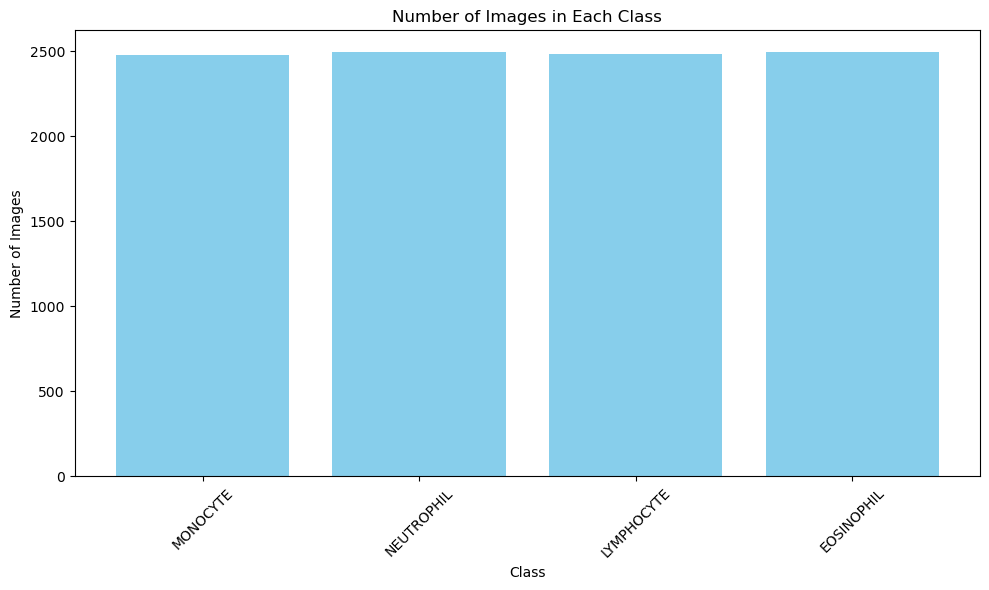

In [7]:
# Class names and their corresponding image counts
class_image_counts = {
    'MONOCYTE': 2478,
    'NEUTROPHIL': 2499,
    'LYMPHOCYTE': 2483,
    'EOSINOPHIL': 2497
}

# Extract class names and image counts
class_names = list(class_image_counts.keys())
image_counts = list(class_image_counts.values())

# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, image_counts, color='skyblue')
plt.title('Number of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

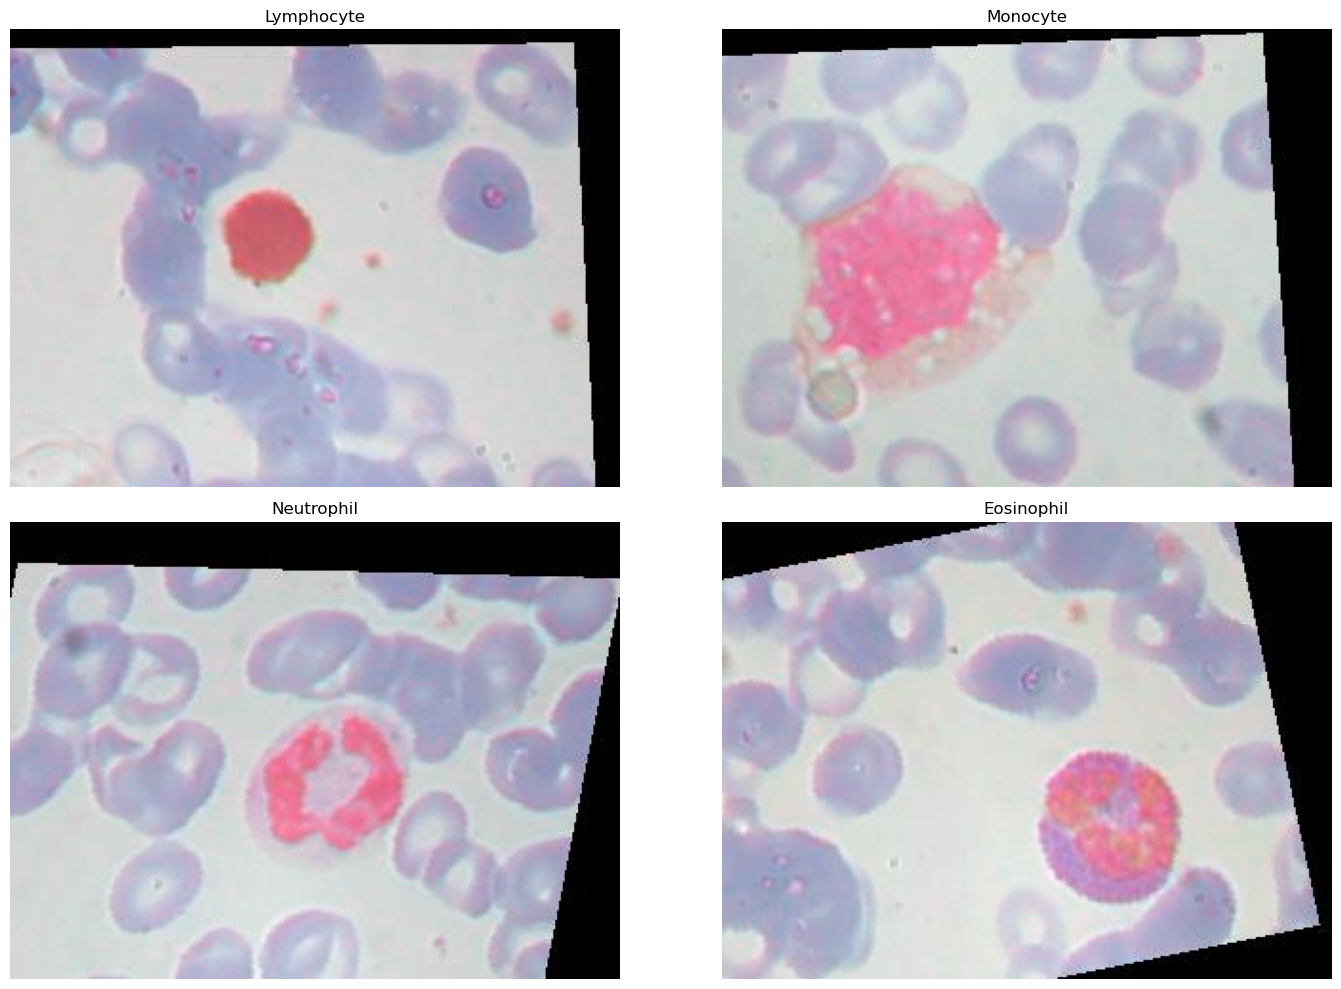

In [8]:
image_paths = [
    '../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_2925.jpeg',
    '../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/_0_2420.jpeg',
    '../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_0_9742.jpeg',
    '../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_1414.jpeg'
]

titles = ['Lymphocyte', 'Monocyte', 'Neutrophil', 'Eosinophil']

plt.figure(figsize=(15, 10))

for i, path in enumerate(image_paths):
    plt.subplot(2, 2, i + 1)
    plt.title(titles[i])
    plt.axis('off')
    plt.imshow(cv2.imread(path))

plt.tight_layout()
plt.show()

In [9]:
# # Get a list of class directories
# class_dirs = [os.path.join(train_path, cls) for cls in os.listdir(train_path)]

# # Extract image dimensions (width and height) for each class
# for cls_dir in class_dirs:
#     class_name = os.path.basename(cls_dir)
    
#     # Get a list of image file paths for the current class
#     image_paths = [os.path.join(cls_dir, file) for file in os.listdir(cls_dir)]
    
#     # Extract dimensions for images in the current class
#     image_dimensions = []
#     for img_path in image_paths:
#         with Image.open(img_path) as img:
#             width, height = img.size
#             image_dimensions.append((width, height))
    
#     # Separate width and height for plotting
#     widths = [dim[0] for dim in image_dimensions]
#     heights = [dim[1] for dim in image_dimensions]
    
#     # Plot histograms for width and height
#     plt.figure(figsize=(12, 6))
    
#     plt.subplot(1, 2, 1)
#     plt.hist(widths, bins=50, color='blue', alpha=0.7)
#     plt.title(f'Distribution of Image Widths - {class_name}')
#     plt.xlabel('Width')
#     plt.ylabel('Frequency')
    
#     plt.subplot(1, 2, 2)
#     plt.hist(heights, bins=50, color='green', alpha=0.7)
#     plt.title(f'Distribution of Image Heights - {class_name}')
#     plt.xlabel('Height')
#     plt.ylabel('Frequency')
    
#     plt.tight_layout()
#     plt.show()
    

In [9]:
train_path
test_path
# Define parameters for data preprocessing and augmentation
batch_size = 32
IMG_SIZE = (224, 224)
validation_split = 0.2  # Proportion of data to be used for validation

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
#     rescale=1./255,
    vertical_flip=True,
    horizontal_flip=True,
    rotation_range=0.2,
    validation_split=validation_split
)

test_datagen = ImageDataGenerator()

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    subset='training'  # Specify subset as 'training' for training set
)

# Flow validation images in batches using train_datagen generator
validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    subset='validation'  # Specify subset as 'validation' for validation set
)

test_generator = test_datagen.flow_from_directory(test_path, 
                                            target_size=IMG_SIZE,
                                            shuffle=False) 

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
IMG_SHAPE

(224, 224, 3)

In [39]:
base_model =  ResNet50(include_top=False, 
                         weights='imagenet', 
                         input_shape=IMG_SHAPE,)

94765736/94765736 [==============================] - 1s 0us/step


In [40]:
for layer in base_model.layers[:140]: layer.trainable = False

In [41]:
model = keras.Sequential()

model.add(layers.Input(shape=IMG_SHAPE))
model.add(layers.Lambda(tf.keras.applications.resnet50.preprocess_input))
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(4, activation="softmax"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_8 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 14,986,244
Non-trainable params: 8,609,664
_________________________________________________________________


In [42]:
model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=['accuracy'])

In [43]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [44]:
callbacks = [
     tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=10, restore_best_weights=True,),
     tf.keras.callbacks.TensorBoard(log_dir='./logs/Resnetlog' , histogram_freq=1),
]

history = model.fit_generator(generator=train_generator, 
#                               steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=validation_generator,  
#                               validation_steps=STEP_SIZE_VALID, 
                              epochs=100, 
                              verbose=1, 
                              callbacks=callbacks)

Epoch 1/100
249/249 [==============================] - 164s 609ms/step - loss: 0.2783 - accuracy: 0.8958 - val_loss: 0.1314 - val_accuracy: 0.9548
Epoch 2/100
249/249 [==============================] - 139s 556ms/step - loss: 0.0619 - accuracy: 0.9797 - val_loss: 0.0511 - val_accuracy: 0.9839
Epoch 3/100
249/249 [==============================] - 154s 620ms/step - loss: 0.0358 - accuracy: 0.9885 - val_loss: 0.0188 - val_accuracy: 0.9950
Epoch 4/100
249/249 [==============================] - 137s 550ms/step - loss: 0.0304 - accuracy: 0.9901 - val_loss: 0.0175 - val_accuracy: 0.9915
Epoch 5/100
249/249 [==============================] - 138s 556ms/step - loss: 0.0143 - accuracy: 0.9961 - val_loss: 0.0203 - val_accuracy: 0.9915
Epoch 6/100
249/249 [==============================] - 137s 551ms/step - loss: 0.0215 - accuracy: 0.9930 - val_loss: 0.0533 - val_accuracy: 0.9879
Epoch 7/100
249/249 [==============================] - 139s 559ms/step - loss: 0.0316 - accuracy: 0.9923 - val_loss: 0

In [86]:
history.history["loss"]

[0.2520873248577118,
 0.06843777745962143,
 0.03720274195075035,
 0.03497341275215149,
 0.01711786538362503,
 0.02177257277071476,
 0.03313693776726723,
 0.004850173369050026,
 0.013470676727592945,
 0.01177096739411354,
 0.011785590089857578,
 0.0027288380078971386,
 0.012711533345282078,
 0.007805003318935633,
 0.01223711296916008,
 0.004104669205844402,
 0.004260971210896969,
 0.009738635271787643,
 0.008058869279921055,
 0.00887514092028141,
 0.01007598452270031,
 0.0054368213750422,
 0.0029529519379138947,
 0.00503972452133894,
 0.006948085036128759,
 0.0010992026655003428]

In [28]:
def plot_history(history):
    # Plot train and validation loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label='Training Loss')
    plt.plot(history.history["val_loss"], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot train and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label='Training Accuracy')
    plt.plot(history.history["val_accuracy"], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

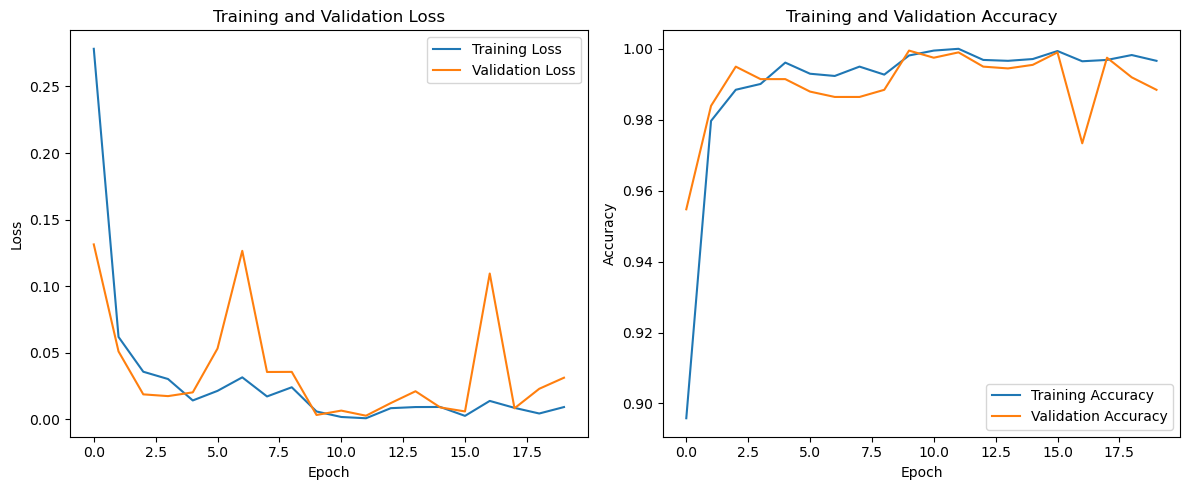

In [45]:
plot_history(history)

In [52]:
# def generate_classification_reports(train_generator, validation_generator, test_generator, model):
#     # Get class names from the training generator
#     CLASS_NAMES = list(train_generator.class_indices.keys())

#     # Function to generate a classification report for a given generator
#     def generate_report(generator, label):
#         # Make predictions
#         predictions = np.argmax(model.predict(generator), axis=1)

#         # Calculate accuracy
#         acc = accuracy_score(generator.labels, predictions)

#         # Calculate confusion matrix
#         cm = tf.math.confusion_matrix(generator.labels, predictions)

#         # Generate classification report
#         clr = classification_report(generator.labels, predictions, target_names=CLASS_NAMES)

#         # Combine all output into a single string
#         report = f"{label} Accuracy: {acc * 100:.3f}%\n"
#         report += f"{label} Classification Report:\n{clr}"

#         # Print the combined report
#         print(report)

#         # Plot confusion matrix
#         plt.figure(figsize=(6, 6))
#         sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Greens', cbar=False)
#         plt.xticks(ticks=np.arange(len(CLASS_NAMES)) + 0.5, labels=CLASS_NAMES, rotation=45)
#         plt.yticks(ticks=np.arange(len(CLASS_NAMES)) + 0.5, labels=CLASS_NAMES)
#         plt.xlabel("Predicted")
#         plt.ylabel("Actual")
#         plt.title(f"{label} Confusion Matrix")
#         plt.show()

#     # Generate reports for train, validation, and test datasets
#     generate_report(train_generator, "Train")
#     generate_report(validation_generator, "Validation")
#     generate_report(test_generator, "Test")

In [53]:
#generate_classification_reports(train_generator, validation_generator, test_generator, model)

In [54]:
def generate_classification_report(train_generator, test_generator, model):
    CLASS_NAMES = list(train_generator.class_indices.keys())
    
    # Make predictions
    predictions = np.argmax(model.predict(test_generator), axis=1)

    # Calculate accuracy
    acc = accuracy_score(test_generator.labels, predictions)

    # Calculate confusion matrix
    cm = tf.math.confusion_matrix(test_generator.labels, predictions)

    # Generate classification report
    clr = classification_report(test_generator.labels, predictions, target_names=CLASS_NAMES)

    # Combine all output into a single string
    report = f"Test Accuracy: {acc * 100:.3f}%\n"
    report += f"Classification Report:\n{clr}"

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Greens', cbar=False)
    plt.xticks(ticks=np.arange(len(CLASS_NAMES)) + 0.5, labels=CLASS_NAMES, rotation=45)
    plt.yticks(ticks=np.arange(len(CLASS_NAMES)) + 0.5, labels=CLASS_NAMES)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Print the combined report
    print(report)

78/78 [==============================] - 8s 102ms/step


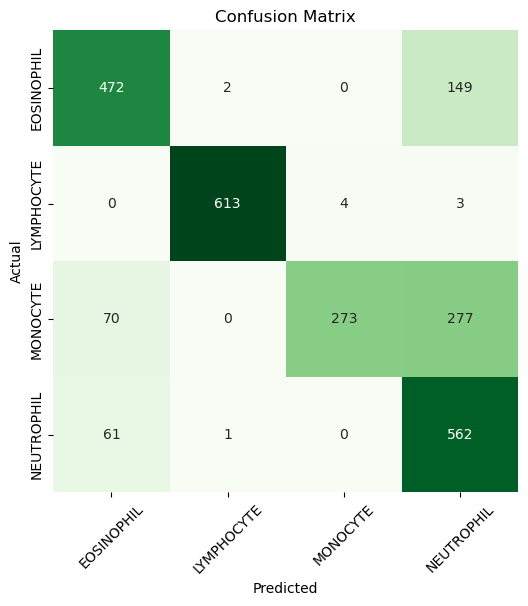

Test Accuracy: 77.201%
Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.78      0.76      0.77       623
  LYMPHOCYTE       1.00      0.99      0.99       620
    MONOCYTE       0.99      0.44      0.61       620
  NEUTROPHIL       0.57      0.90      0.70       624

    accuracy                           0.77      2487
   macro avg       0.83      0.77      0.77      2487
weighted avg       0.83      0.77      0.77      2487



In [55]:
generate_classification_report(train_generator, test_generator, model)

In [18]:
vgg_base = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             weights='imagenet')

In [19]:
vgg_model = keras.Sequential()
for layer in vgg_base.layers[:-4]: layer.trainable=False

In [20]:
# for layer in vgg_base.layers[:50]:
#     layer.trainable = False

In [21]:
# Add the vgg convolutional base model
vgg_model.add(vgg_base)
 
# Add new layers
vgg_model.add(Flatten())
vgg_model.add(BatchNormalization())
vgg_model.add(Dense(32, activation='relu' ))
vgg_model.add(Dropout(0.2))
vgg_model.add(BatchNormalization())
vgg_model.add(Dense(16, activation='relu' ))
vgg_model.add(Dropout(0.2))
vgg_model.add(BatchNormalization())
vgg_model.add(Dense(8, activation='relu' ))
vgg_model.add(Dropout(0.2))
vgg_model.add(BatchNormalization())
vgg_model.add(Dense(4, activation='softmax'))

In [ ]:
vgg_model.summary()

In [23]:
vgg_model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=['accuracy'])

In [ ]:
# vgg_model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(lr=1e-4),
#               metrics=['acc'])

In [25]:
callbacks = [
     tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=10, restore_best_weights=True,),
     tf.keras.callbacks.TensorBoard(log_dir='./logs/Vgglog' , histogram_freq=1),
]

vgg_history = vgg_model.fit_generator(generator=train_generator, 
#                               steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=validation_generator,  
#                               validation_steps=STEP_SIZE_VALID, 
                              epochs=100, 
                              verbose=1, 
                              callbacks=callbacks)

Epoch 1/100
249/249 [==============================] - 133s 533ms/step - loss: 1.1754 - accuracy: 0.4543 - val_loss: 1.2309 - val_accuracy: 0.3881
Epoch 2/100
249/249 [==============================] - 128s 513ms/step - loss: 0.9488 - accuracy: 0.5911 - val_loss: 132.4688 - val_accuracy: 0.2810
Epoch 3/100
249/249 [==============================] - 127s 509ms/step - loss: 0.7079 - accuracy: 0.7290 - val_loss: 3.0915 - val_accuracy: 0.4268
Epoch 4/100
249/249 [==============================] - 127s 509ms/step - loss: 0.5147 - accuracy: 0.8085 - val_loss: 6.6113 - val_accuracy: 0.2509
Epoch 5/100
249/249 [==============================] - 127s 511ms/step - loss: 0.6474 - accuracy: 0.7452 - val_loss: 9.6087 - val_accuracy: 0.2509
Epoch 6/100
249/249 [==============================] - 127s 509ms/step - loss: 0.4620 - accuracy: 0.8261 - val_loss: 12.1103 - val_accuracy: 0.2509
Epoch 7/100
249/249 [==============================] - 127s 511ms/step - loss: 0.3691 - accuracy: 0.8680 - val_loss

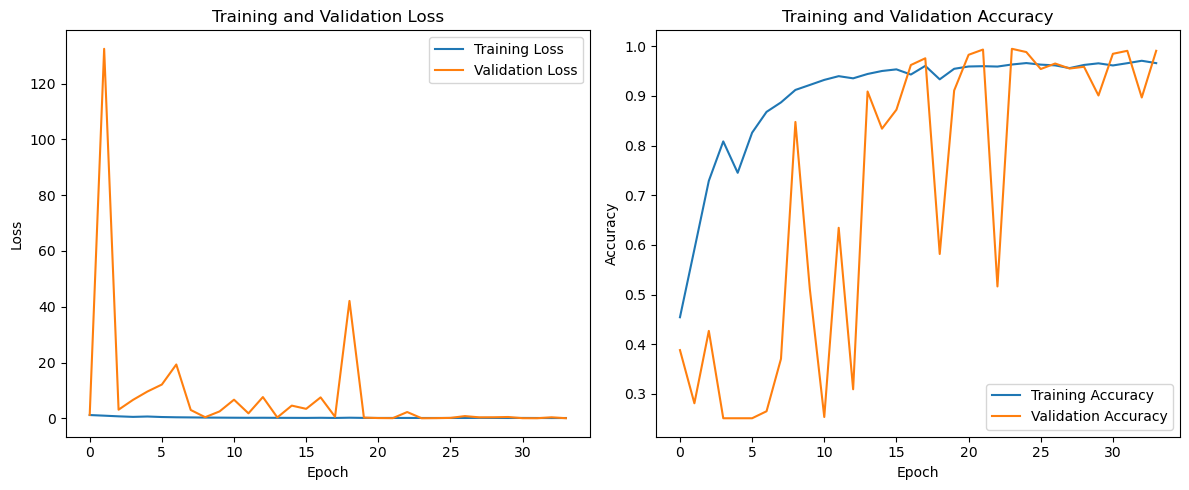

In [29]:
plot_history(vgg_history)

78/78 [==============================] - 26s 328ms/step


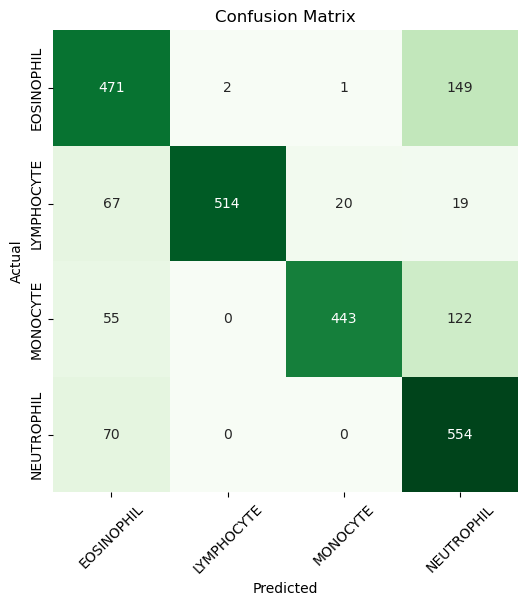

Test Accuracy: 79.694%
Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.71      0.76      0.73       623
  LYMPHOCYTE       1.00      0.83      0.90       620
    MONOCYTE       0.95      0.71      0.82       620
  NEUTROPHIL       0.66      0.89      0.75       624

    accuracy                           0.80      2487
   macro avg       0.83      0.80      0.80      2487
weighted avg       0.83      0.80      0.80      2487



In [30]:
generate_classification_report(train_generator, test_generator, vgg_model)

In [31]:
base_inception = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

87910968/87910968 [==============================] - 0s 0us/step


In [32]:
inception_model = keras.Sequential()
for layer in base_inception.layers[:-40]: layer.trainable = False

In [33]:
# Add the vgg convolutional base model
inception_model.add(base_inception)
 
# Add new layers
inception_model.add(Flatten())
inception_model.add(BatchNormalization())
inception_model.add(Dense(32, activation='relu' ))
inception_model.add(Dropout(0.2))
inception_model.add(BatchNormalization())
inception_model.add(Dense(16, activation='relu' ))
inception_model.add(Dropout(0.2))
inception_model.add(BatchNormalization())
inception_model.add(Dense(8, activation='relu' ))
inception_model.add(Dropout(0.2))
inception_model.add(BatchNormalization())
inception_model.add(Dense(4, activation='softmax'))

In [34]:
inception_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 batch_normalization_98 (Bat  (None, 51200)            204800    
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 32)                1638432   
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_99 (Bat  (None, 32)               128       
 chNormalization)                                     

In [35]:
inception_model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=['accuracy'])

In [36]:
callbacks = [
     tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=10, restore_best_weights=True,),
     tf.keras.callbacks.TensorBoard(log_dir='./logs/Inceptionlog' , histogram_freq=1),
]

inception_history = inception_model.fit_generator(generator=train_generator, 
#                               steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=validation_generator,  
#                               validation_steps=STEP_SIZE_VALID, 
                              epochs=100, 
                              verbose=1, 
                              callbacks=callbacks)

Epoch 1/100
249/249 [==============================] - 177s 516ms/step - loss: 1.5282 - accuracy: 0.3050 - val_loss: 1.3693 - val_accuracy: 0.3389
Epoch 2/100
249/249 [==============================] - 123s 495ms/step - loss: 1.3234 - accuracy: 0.3857 - val_loss: 1.2358 - val_accuracy: 0.4143
Epoch 3/100
249/249 [==============================] - 124s 498ms/step - loss: 1.2321 - accuracy: 0.4396 - val_loss: 1.1587 - val_accuracy: 0.4892
Epoch 4/100
249/249 [==============================] - 124s 498ms/step - loss: 1.1587 - accuracy: 0.4757 - val_loss: 1.0508 - val_accuracy: 0.5465
Epoch 5/100
249/249 [==============================] - 133s 534ms/step - loss: 1.1134 - accuracy: 0.5114 - val_loss: 1.0654 - val_accuracy: 0.5485
Epoch 6/100
249/249 [==============================] - 139s 557ms/step - loss: 1.0545 - accuracy: 0.5443 - val_loss: 1.6998 - val_accuracy: 0.4163
Epoch 7/100
249/249 [==============================] - 136s 546ms/step - loss: 1.0084 - accuracy: 0.5673 - val_loss: 1

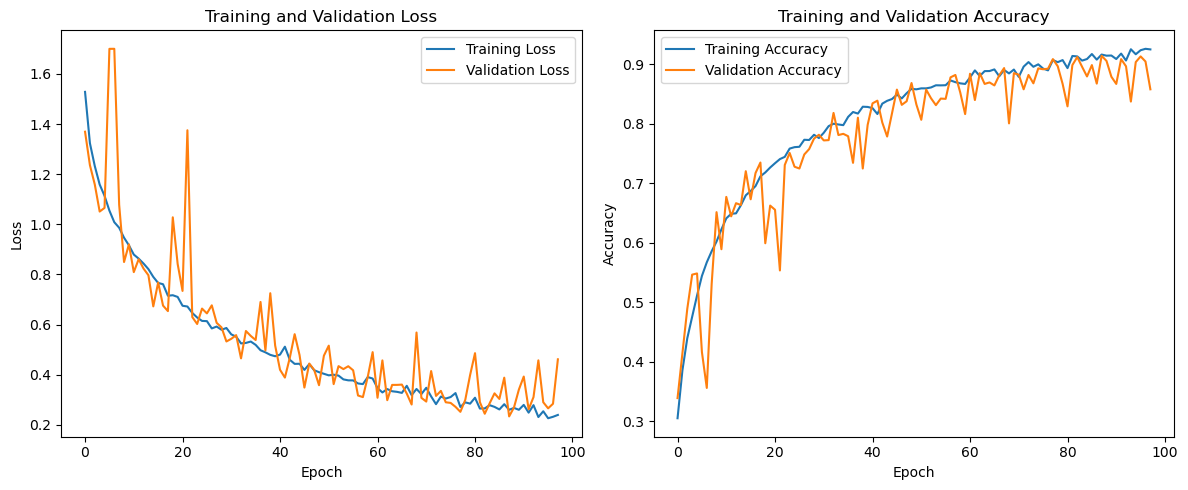

In [37]:
plot_history(inception_history)

78/78 [==============================] - 12s 131ms/step


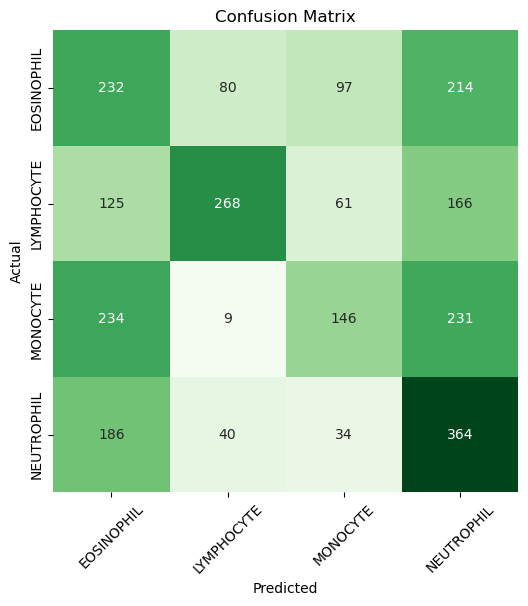

Test Accuracy: 40.611%
Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.30      0.37      0.33       623
  LYMPHOCYTE       0.68      0.43      0.53       620
    MONOCYTE       0.43      0.24      0.30       620
  NEUTROPHIL       0.37      0.58      0.46       624

    accuracy                           0.41      2487
   macro avg       0.44      0.41      0.40      2487
weighted avg       0.44      0.41      0.40      2487



In [38]:
generate_classification_report(train_generator, test_generator, inception_model)